In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim 
from torch.utils.data import DataLoader, TensorDataset

***READING IN THE MODEL***

In [2]:
df = pd.read_csv(r'/kaggle/input/yeast-dataset/yeast.xls')
df

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT
...,...,...,...,...,...,...,...,...,...
1479,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,ME2
1480,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,NUC
1481,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,ME2
1482,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,NUC


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mcg     1484 non-null   float64
 1   gvh     1484 non-null   float64
 2   alm     1484 non-null   float64
 3   mit     1484 non-null   float64
 4   erl     1484 non-null   float64
 5   pox     1484 non-null   float64
 6   vac     1484 non-null   float64
 7   nuc     1484 non-null   float64
 8   name    1484 non-null   object 
dtypes: float64(8), object(1)
memory usage: 104.5+ KB


***DESCRIPTION***

In [4]:
df.describe()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
mean,0.500121,0.499933,0.500034,0.261186,0.504717,0.007500,0.499885,0.276199
std,0.137299,0.123924,0.086670,0.137098,0.048351,0.075683,0.057797,0.106491
min,0.110000,0.130000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.410000,0.420000,0.460000,0.170000,0.500000,0.000000,0.480000,0.220000
50%,0.490000,0.490000,0.510000,0.220000,0.500000,0.000000,0.510000,0.220000
75%,0.580000,0.570000,0.550000,0.320000,0.500000,0.000000,0.530000,0.300000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.830000,0.730000,1.000000


***CHECKING FOR MISSING VALUES***

In [5]:
df.isna().sum()

mcg     0
gvh     0
alm     0
mit     0
erl     0
pox     0
vac     0
nuc     0
name    0
dtype: int64

***HIST PLOT OF FEATURES***

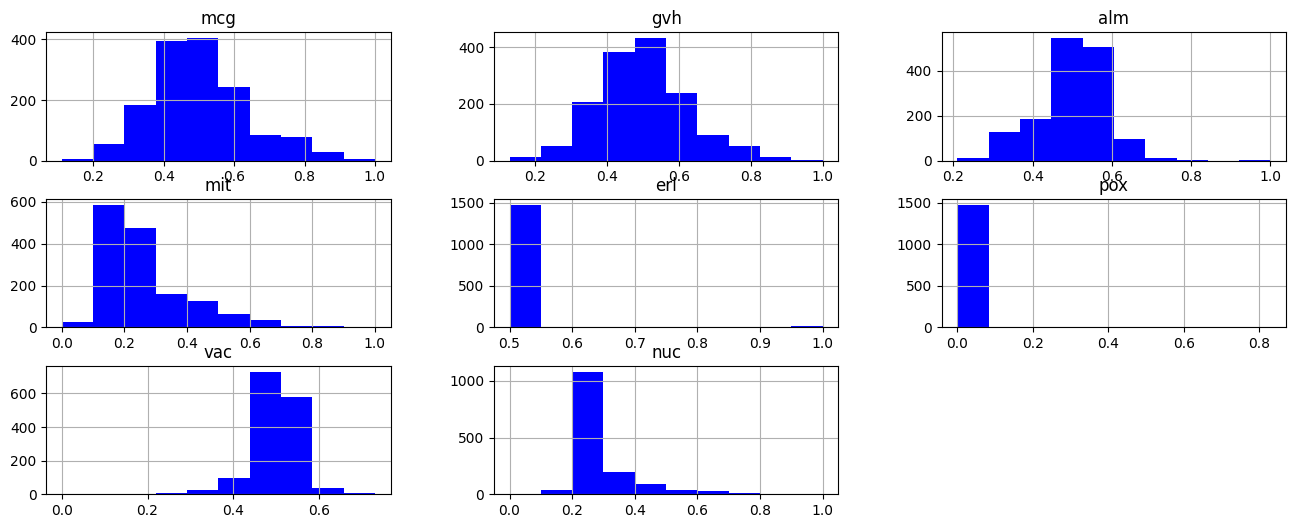

In [6]:
df.hist(figsize=(16, 6), color='blue');

***RENAMING THE TARGET COLUMN***

In [7]:
df.rename(columns = {'name':'localization_site'}, inplace=True)

***TARGET COLUMN DESCRIPTION***

localization_site
CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: count, dtype: int64


<Axes: xlabel='localization_site'>

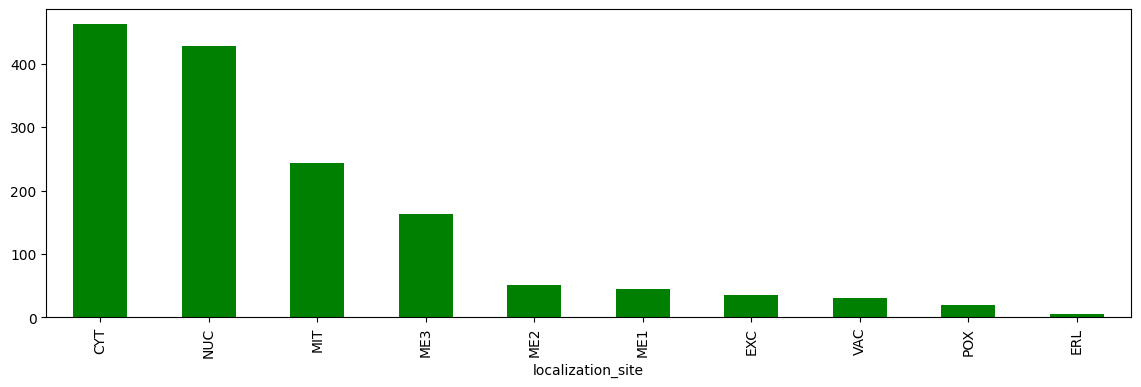

In [8]:
print(df['localization_site'].value_counts())
df['localization_site'].value_counts().plot(kind='bar', figsize=(14, 4), color='green')

***CORRELATION MATRIX***

<Axes: >

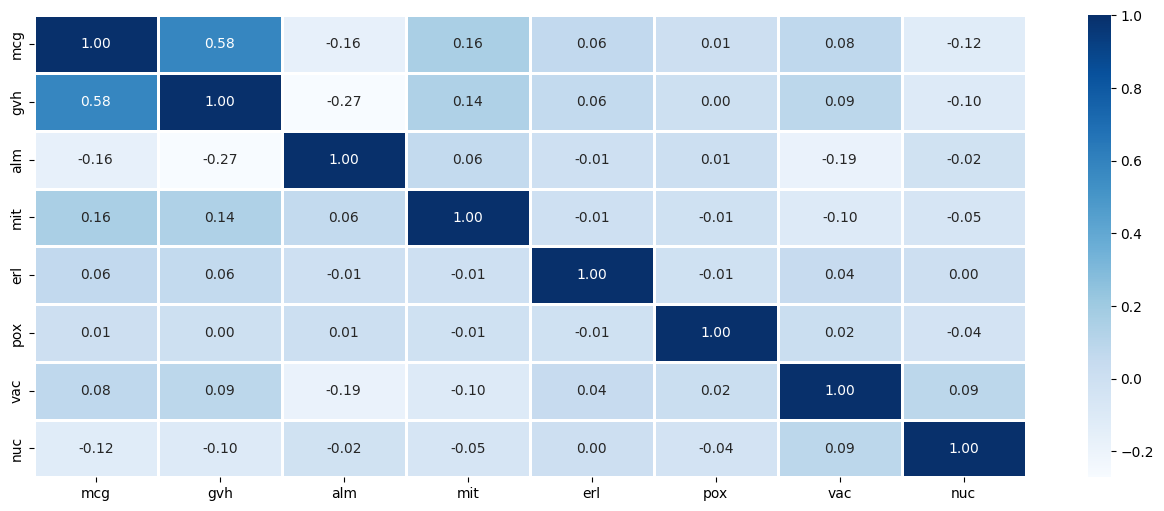

In [9]:
correlation = df.drop('localization_site', axis=1).corr()
plt.figure(figsize=(16, 6))
sns.heatmap(correlation, cmap='Blues', annot=True, fmt='.2f', lw=1)

***SPLITTING TARGET AND INPUT FEATURES***

In [10]:
X = df.drop('localization_site', axis=1)   # INPUT FEATURES
y = df['localization_site']               # TARGET FEATURE


print("Input shape:", X.shape)
print("Target shape:", y.shape)

Input shape: (1484, 8)
Target shape: (1484,)


***ENCODING THE TARGET COLUMN***

In [11]:
label_encoder = LabelEncoder()       # LABEL ENCODER
y_encoded = label_encoder.fit_transform(y)  # FITTING THE TARGET COLUMN TO THE ENCODER
classes_names = label_encoder.classes_         # TARGET COLUMN CLASSES

***SCALING THE INPUT FEATURES***

In [12]:
scaler = StandardScaler()       # SCALER
X_scaled = scaler.fit_transform(X)  # FITTING THE INPUT FEATURES

***SPLITTING THE TRAIN AND TEST SETS AND CONVERTING TO TENSORS***

In [13]:
from sklearn.model_selection import train_test_split
import torch

# --------------------------------------------------------------
#  Split the dataset into training and testing sets
# --------------------------------------------------------------
# - X_scaled: your normalized or standardized feature matrix
# - y_encoded: your encoded labels (numeric form)
# - test_size=0.2 means 20% test, 80% train
# - random_state ensures reproducibility
# - stratify=y_encoded ensures class balance in both splits
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

# --------------------------------------------------------------
# Convert NumPy arrays to PyTorch tensors
# --------------------------------------------------------------
# Convert features (X) to float32 tensors — required for neural networks
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Convert labels (y) to long tensors — required by nn.CrossEntropyLoss
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# --------------------------------------------------------------
#  Print shapes to verify data dimensions
# --------------------------------------------------------------
print("X_train shape:", X_train_tensor.shape)   # e.g., torch.Size([N_train, num_features])
print("X_test shape:", X_test_tensor.shape)     # e.g., torch.Size([N_test, num_features])
print("y_train shape:", y_train_tensor.shape)   # e.g., torch.Size([N_train])
print("y_test shape:", y_test_tensor.shape)     # e.g., torch.Size([N_test])

# --------------------------------------------------------------
# Print the number of unique classes (from LabelEncoder)
# --------------------------------------------------------------
print("Length of classes:", len(label_encoder.classes_))


X_train shape: torch.Size([1187, 8])
X_test shape: torch.Size([297, 8])
y_train shape: torch.Size([1187])
y_test shape: torch.Size([297])
Length of classes: 10
X_train shape: torch.Size([1187, 8])
X_test shape: torch.Size([297, 8])
y_train shape: torch.Size([1187])
y_test shape: torch.Size([297])
Length of classes: 10


***BUILDING A NEURAL NETWORK***

In [ ]:
import torch
import torch.nn as nn

# --------------------------------------------------------------
# Define a simple feedforward neural network for the Yeast dataset
# --------------------------------------------------------------
class yeast_model(nn.Module):
    def __init__(self):
        # Initialize the parent nn.Module class
        super(yeast_model, self).__init__()

        # Define the model architecture using nn.Sequential
        #  - Input layer: 8 features → 32 hidden neurons
        #  - Activation: ReLU (introduces non-linearity)
        #  - Output layer: 32 → 10 neurons (for 10 yeast classes)
        self.model = nn.Sequential(
            nn.Linear(8, 32),   # Fully connected layer (input → hidden)
            nn.ReLU(),          # Non-linear activation
            nn.Linear(32, 10)   # Fully connected layer (hidden → output)
        )

    # Define the forward pass (how data flows through the network)
    def forward(self, x):
        return self.model(x)   # Pass input through the defined layers

# --------------------------------------------------------------
# Instantiate the model
# --------------------------------------------------------------
model = yeast_model()

# Print model architecture summary
print(model)


In [15]:
# --------------------------------------------------------------
# Full-Batch Gradient Descent using Adam Optimizer in PyTorch
# --------------------------------------------------------------

import torch
import torch.nn as nn

# --------------------------------------------------------------
# Define loss function and optimizer
# --------------------------------------------------------------
model_ad = yeast_model()
criterion = nn.CrossEntropyLoss()                          # Multi-class classification loss
optimizer = torch.optim.Adam(model_ad.parameters(), lr=0.01)   # Adam optimizer with learning rate = 0.1

# --------------------------------------------------------------
# Initialize metric storage
# --------------------------------------------------------------
train_losses = []
train_accuracies = []
num_epoch = 100  # Number of training iterations (epochs)

# --------------------------------------------------------------
# Training Loop
# --------------------------------------------------------------
for epoch in range(num_epoch):

    # ----------------------------------------------------------
    # Forward Pass: Compute predictions and loss
    # ----------------------------------------------------------
    logits = model_ad(X_train_tensor)             # Full-batch forward pass
    loss = criterion(logits, y_train_tensor)   # Compute cross-entropy loss

    # ----------------------------------------------------------
    # Backward Pass: Gradient computation and update
    # ----------------------------------------------------------
    optimizer.zero_grad()   # Reset accumulated gradients
    loss.backward()         # Compute new gradients
    optimizer.step()        # Update model parameters

    # ----------------------------------------------------------
    # Track metrics
    # ----------------------------------------------------------
    train_losses.append(loss.item())

    # Compute accuracy
    preds = torch.argmax(logits, dim=1)                     # Get predicted classes
    correct = (preds == y_train_tensor).sum().item()        # Count correct predictions
    accuracy = correct / len(y_train_tensor)                # Compute accuracy
    train_accuracies.append(accuracy)

    # ----------------------------------------------------------
    # Print progress every 10 epochs
    # ----------------------------------------------------------
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1:3d} | Loss: {loss.item():.3f} | Train Acc: {accuracy * 100:.2f}%")


Epoch  10 | Loss: 1.569 | Train Acc: 47.94%
Epoch  20 | Loss: 1.237 | Train Acc: 55.60%
Epoch  30 | Loss: 1.124 | Train Acc: 58.97%
Epoch  40 | Loss: 1.063 | Train Acc: 60.91%
Epoch  50 | Loss: 1.028 | Train Acc: 62.09%
Epoch  60 | Loss: 1.005 | Train Acc: 62.85%
Epoch  70 | Loss: 0.988 | Train Acc: 63.35%
Epoch  80 | Loss: 0.973 | Train Acc: 63.52%
Epoch  90 | Loss: 0.961 | Train Acc: 63.44%
Epoch 100 | Loss: 0.949 | Train Acc: 64.20%


***OPTIMIZATION***

In [16]:
import torch
import torch.nn as nn

# --------------------------------------------------------------
# Define a simple feedforward neural network for the Yeast dataset
# --------------------------------------------------------------
class yeast_model(nn.Module):
    def __init__(self, input_dim ,hidden_layer, output_dim):
        # Initialize the parent nn.Module class
        super(yeast_model, self).__init__()

        # Define the model architecture using nn.Sequential
        #  - Input layer: 8 features → 32 hidden neurons
        #  - Activation: ReLU (introduces non-linearity)
        #  - Output layer: 32 → 10 neurons (for 10 yeast classes)
        self.model = nn.Sequential(
            nn.Linear(8, 32),   # Fully connected layer (input → hidden)
            nn.ReLU(),          # Non-linear activation
            nn.Linear(32, 10)   # Fully connected layer (hidden → output)
        )

    # Define the forward pass (how data flows through the network)
    def forward(self, x):
        return self.model(x)   # Pass input through the defined layers

input_dim = X_train_tensor.shape[1]      # 8 features
hidden_layer = 16
output_dim = len(label_encoder.classes_) 

# --------------------------------------------------------------
# Instantiate the model
# --------------------------------------------------------------
model = yeast_model(input_dim, hidden_layer, output_dim)

# Print model architecture summary
print(model)


yeast_model(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [17]:

# Combine features and labels into a single training dataset
Train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Combine features and labels into a single test dataset
Test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for training set (batches of 32, shuffled each epoch)
train_loader = DataLoader(Train_dataset, batch_size=32, shuffle=True)

# Create DataLoader for test set (batches of 32, no shuffling)
test_loader = DataLoader(Test_dataset, batch_size=32, shuffle=False)




# Check shapes and class info
print(" Train set:", X_train_tensor.shape)
print(" Test set:", X_test_tensor.shape)
print(" Number of Classes:", len(label_encoder.classes_))
print(" Class Names:", label_encoder.classes_)


 Train set: torch.Size([1187, 8])
 Test set: torch.Size([297, 8])
 Number of Classes: 10
 Class Names: ['CYT' 'ERL' 'EXC' 'ME1' 'ME2' 'ME3' 'MIT' 'NUC' 'POX' 'VAC']


***======================================================================***  
***NOTE: Understanding SGD, Full-Batch, and Mini-Batch Optimizers in ML***  
***======================================================================***  

***--------------------------------------------------------------***  
***1️⃣ Full-Batch Gradient Descent***  
***--------------------------------------------------------------***  
▪ ***Description:***  
   - Uses the **entire training dataset** to compute the gradient at each step.  
   - The model parameters are updated **only once per epoch**.  

▪ ***Advantages:***  
   - Produces a **stable and accurate** estimate of the gradient.  
   - **Guarantees convergence** for convex problems.  

▪ ***Disadvantages:***  
   - **Computationally expensive** for large datasets.  
   - **Slow training** since it processes all samples before one update.  

***--------------------------------------------------------------***  
***2️⃣ Stochastic Gradient Descent (SGD)***  
***--------------------------------------------------------------***  
▪ ***Description:***  
   - Updates model parameters after computing the gradient on a **single sample**.  
   - The model updates **more frequently**, introducing randomness (noise).  

▪ ***Advantages:***  
   - **Fast updates** → quicker learning in early epochs.  
   - Helps **escape local minima** due to random fluctuations.  

▪ ***Disadvantages:***  
   - **Noisy loss curve** (fluctuates a lot).  
   - **Unstable convergence** without proper learning rate scheduling.  

***--------------------------------------------------------------***  
***3️⃣ Mini-Batch Gradient Descent***  
***--------------------------------------------------------------***  
▪ ***Description:***  
   - A **compromise** between Full-Batch and SGD.  
   - Divides the training data into **small batches** (e.g., 32, 64, 128 samples).  
   - Updates model weights after **each batch**.  

▪ ***Advantages:***  
   - **Faster** than Full-Batch but **more stable** than SGD.  
   - Enables **efficient GPU computation** (vectorized operations).  
   - **Commonly used** in deep learning.  

▪ ***Disadvantages:***  
   - Requires **tuning of batch size**.  
   - Still **slightly noisy**, though much smoother than SGD.  

***--------------------------------------------------------------***  
***💡 Summary***  
***--------------------------------------------------------------***  
- **Full-Batch → Stable but Slow**  
- **SGD → Fast but Noisy**  
- **Mini-Batch → Balanced (Best for Deep Learning)**  

✅ ***Most real-world neural networks use Mini-Batch Gradient Descent***  
***with adaptive optimizers like Adam, RMSProp, or SGD with Momentum.***  
***--------------------------------------------------------------***


***FULL BATCH GRADIENT DESCENT OPTMIZER***

In [18]:
# --------------------------------------------------------------
# Full-Batch Gradient Descent (SGD) Training in PyTorch
# --------------------------------------------------------------

import torch
import torch.nn as nn

# Define optimizer and loss function
model_gd = yeast_model(input_dim, hidden_layer, output_dim)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)  # Full-batch GD
loss_fn = nn.CrossEntropyLoss()                          # Classification loss

# Track metrics
train_losses_gd = []
train_accuracy_gd = []

num_epochs = 100  # Number of full passes through the dataset

# --------------------------------------------------------------
# Training Loop
# --------------------------------------------------------------
for epoch in range(num_epochs):
    model.train()  # Set model to training mode (important for dropout/batchnorm)

    # ----------------------------------------------------------
    # Forward pass: compute predictions and loss
    # ----------------------------------------------------------
    logits = model(X_train_tensor)             # All samples at once (full-batch)
    loss = loss_fn(logits, y_train_tensor)

    # ----------------------------------------------------------
    # Backward pass: compute gradients and update weights
    # ----------------------------------------------------------
    optimizer.zero_grad()   #  Added parentheses 
    loss.backward()
    optimizer.step()

    # ----------------------------------------------------------
    # Compute accuracy
    # ----------------------------------------------------------
    preds = torch.argmax(logits, dim=1)                # Get predicted classes
    correct = (preds == y_train_tensor).float().mean().item()  # Mean accuracy

    # ----------------------------------------------------------
    # Store metrics
    # ----------------------------------------------------------
    train_losses_gd.append(loss.item())
    train_accuracy_gd.append(correct)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"[FULL-BATCH] Epoch {epoch + 1:3d} | Loss: {loss.item():.4f} | Accuracy: {correct * 100:.2f}%")


[FULL-BATCH] Epoch  10 | Loss: 2.0515 | Accuracy: 30.67%
[FULL-BATCH] Epoch  20 | Loss: 1.8104 | Accuracy: 35.64%
[FULL-BATCH] Epoch  30 | Loss: 1.6436 | Accuracy: 40.19%
[FULL-BATCH] Epoch  40 | Loss: 1.5242 | Accuracy: 47.35%
[FULL-BATCH] Epoch  50 | Loss: 1.4353 | Accuracy: 51.81%
[FULL-BATCH] Epoch  60 | Loss: 1.3671 | Accuracy: 53.16%
[FULL-BATCH] Epoch  70 | Loss: 1.3138 | Accuracy: 53.50%
[FULL-BATCH] Epoch  80 | Loss: 1.2717 | Accuracy: 54.59%
[FULL-BATCH] Epoch  90 | Loss: 1.2380 | Accuracy: 55.60%
[FULL-BATCH] Epoch 100 | Loss: 1.2106 | Accuracy: 56.70%


***STOCHASTIC GRADIENT DESECNT OPTIMIZER***

In [19]:
# STOCHASTIC GRADIENT DESCENT

# --------------------------------------------------------------
# Set seed for reproducibility
# --------------------------------------------------------------
torch.manual_seed(42)
import random

# --------------------------------------------------------------
# Create a new model instance (same structure as before)
# --------------------------------------------------------------
# Assuming yeast_model is your neural network class (e.g., YeastMLP)
model_sgd = yeast_model(input_dim, hidden_layer, output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()                    # For multi-class classification
optimizer = torch.optim.SGD(model_sgd.parameters(), lr=0.005)  # Stochastic Gradient Descent

# --------------------------------------------------------------
# Initialize lists to store loss and accuracy over epochs
# --------------------------------------------------------------
train_losses_sgd = []
train_accuracy_sgd = []

# --------------------------------------------------------------
# Convert training tensors into list of (feature, label) pairs
# --------------------------------------------------------------
# This allows us to iterate sample-by-sample (true SGD)
train_samples = list(zip(X_train_tensor, y_train_tensor))

# (Optional) Track training time
# start_time = time.perf_counter()

# --------------------------------------------------------------
# Training loop – one epoch processes all samples individually
# --------------------------------------------------------------
for epoch in range(100):
    epoch_loss = 0.0
    correct = 0

    # Shuffle training samples at the start of each epoch
    torch.random.manual_seed(epoch)   # Ensures deterministic shuffling
    shuffled_samples = train_samples.copy()
    random.shuffle(shuffled_samples)

    # ----------------------------------------------------------
    # Iterate through each sample (stochastic update per sample)
    # ----------------------------------------------------------
    for x_sample, y_sample in shuffled_samples:
        # Add batch dimension since model expects 2D input: (batch_size, features)
        x_sample = x_sample.unsqueeze(0)
        y_sample = y_sample.unsqueeze(0)

        # Forward pass
        outputs = model_sgd(x_sample)
        loss = criterion(outputs, y_sample)

        # Backward pass and parameter update
        optimizer.zero_grad()   # Clear previous gradients
        loss.backward()         # Compute gradients for this sample
        optimizer.step()        # Update weights immediately

        # Track metrics
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == y_sample).sum().item()

    # ----------------------------------------------------------
    # Compute average loss and accuracy for the epoch
    # ----------------------------------------------------------
    avg_loss = epoch_loss / len(train_samples)
    accuracy = correct / len(train_samples)

    train_losses_sgd.append(avg_loss)
    train_accuracy_sgd.append(accuracy)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"[SGD] Epoch {epoch+1:>2} | Loss: {avg_loss:.4f} | Accuracy: {accuracy*100:.2f}%")

# (Optional) Print training time
# end_time = time.perf_counter()
# print(f"Training completed in {end_time - start_time:.2f} seconds")


[SGD] Epoch 10 | Loss: 1.0293 | Accuracy: 61.16%
[SGD] Epoch 20 | Loss: 0.9823 | Accuracy: 62.59%
[SGD] Epoch 30 | Loss: 0.9569 | Accuracy: 62.51%
[SGD] Epoch 40 | Loss: 0.9468 | Accuracy: 63.77%
[SGD] Epoch 50 | Loss: 0.9320 | Accuracy: 64.70%
[SGD] Epoch 60 | Loss: 0.9174 | Accuracy: 65.12%
[SGD] Epoch 70 | Loss: 0.9025 | Accuracy: 65.12%
[SGD] Epoch 80 | Loss: 0.8967 | Accuracy: 65.88%
[SGD] Epoch 90 | Loss: 0.8907 | Accuracy: 64.53%
[SGD] Epoch 100 | Loss: 0.8850 | Accuracy: 65.04%


***MINI_BATCH STOCHASTIC GRADIENT DESCENT***

In [20]:
# MINI BATCH SGD

# --------------------------------------------------------------
# Define hyperparameters
# --------------------------------------------------------------
batch_size = 32        # Number of samples per mini-batch
epochs = 100           # Number of full passes through the dataset
learning_rate = 0.01   # Step size for weight updates

# --------------------------------------------------------------
# Re-initialize model, loss function, and optimizer
# --------------------------------------------------------------
model_mb = yeast_model(input_dim, hidden_layer, output_dim)
criterion = nn.CrossEntropyLoss()                       # Suitable for multi-class classification
optimizer_mb = torch.optim.SGD(model_mb.parameters(), lr=learning_rate)  # Mini-batch SGD optimizer

# --------------------------------------------------------------
# Create DataLoader for mini-batch processing
# --------------------------------------------------------------
# Combines input features and labels into a TensorDataset
# DataLoader automatically handles batching and shuffling
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# --------------------------------------------------------------
# Initialize lists to store loss and accuracy for each epoch
# --------------------------------------------------------------
train_losses_mb = []
train_accuracy_mb = []

# (Optional) Track training time
# start_time = time.perf_counter()

# --------------------------------------------------------------
# Training loop
# --------------------------------------------------------------
for epoch in range(epochs):
    model_mb.train()       # Set model to training mode
    epoch_loss = 0.0       # Accumulate total loss per epoch
    correct = 0            # Count correct predictions
    total = 0              # Count total samples

    # Iterate through mini-batches
    for X_batch, y_batch in train_loader:
        # Forward pass: compute model output
        outputs = model_mb(X_batch)

        # Compute loss for the batch
        loss = criterion(outputs, y_batch)

        # Backward pass: compute gradients
        optimizer_mb.zero_grad()  # Clear existing gradients
        loss.backward()            # Compute new gradients
        optimizer_mb.step()        # Update model weights

        # Track total loss (multiply by batch size to get full sample loss)
        epoch_loss += loss.item() * X_batch.size(0)

        # Track accuracy: compare predicted vs actual labels
        _, predicted = torch.max(outputs, 1)             # Get predicted class (highest logit)
        correct += (predicted == y_batch).sum().item()   # Count correct predictions
        total += y_batch.size(0)                         # Count total samples processed

    # Compute average loss and accuracy for the epoch
    avg_loss = epoch_loss / total
    acc = correct / total

    # Store metrics for later visualization
    train_losses_mb.append(avg_loss)
    train_accuracy_mb.append(acc)

    # Print training progress
    print(f"[Mini-Batch] Epoch {epoch+1:2d}: Loss = {avg_loss:.4f} | Accuracy = {acc*100:.4f}")

# (Optional) Measure total training time
# end_time = time.perf_counter()
# print(f"Training completed in {end_time - start_time:.2f} seconds")


[Mini-Batch] Epoch  1: Loss = 2.2999 | Accuracy = 11.4575
[Mini-Batch] Epoch  2: Loss = 2.1785 | Accuracy = 29.4861
[Mini-Batch] Epoch  3: Loss = 2.0747 | Accuracy = 35.3833
[Mini-Batch] Epoch  4: Loss = 1.9854 | Accuracy = 37.0682
[Mini-Batch] Epoch  5: Loss = 1.9074 | Accuracy = 39.2586
[Mini-Batch] Epoch  6: Loss = 1.8371 | Accuracy = 39.7641
[Mini-Batch] Epoch  7: Loss = 1.7730 | Accuracy = 41.0278
[Mini-Batch] Epoch  8: Loss = 1.7142 | Accuracy = 42.1230
[Mini-Batch] Epoch  9: Loss = 1.6600 | Accuracy = 44.4819
[Mini-Batch] Epoch 10: Loss = 1.6109 | Accuracy = 46.0826
[Mini-Batch] Epoch 11: Loss = 1.5667 | Accuracy = 48.2730
[Mini-Batch] Epoch 12: Loss = 1.5258 | Accuracy = 49.5366
[Mini-Batch] Epoch 13: Loss = 1.4881 | Accuracy = 50.5476
[Mini-Batch] Epoch 14: Loss = 1.4545 | Accuracy = 52.7380
[Mini-Batch] Epoch 15: Loss = 1.4228 | Accuracy = 52.6537
[Mini-Batch] Epoch 16: Loss = 1.3940 | Accuracy = 53.4962
[Mini-Batch] Epoch 17: Loss = 1.3677 | Accuracy = 53.6647
[Mini-Batch] E

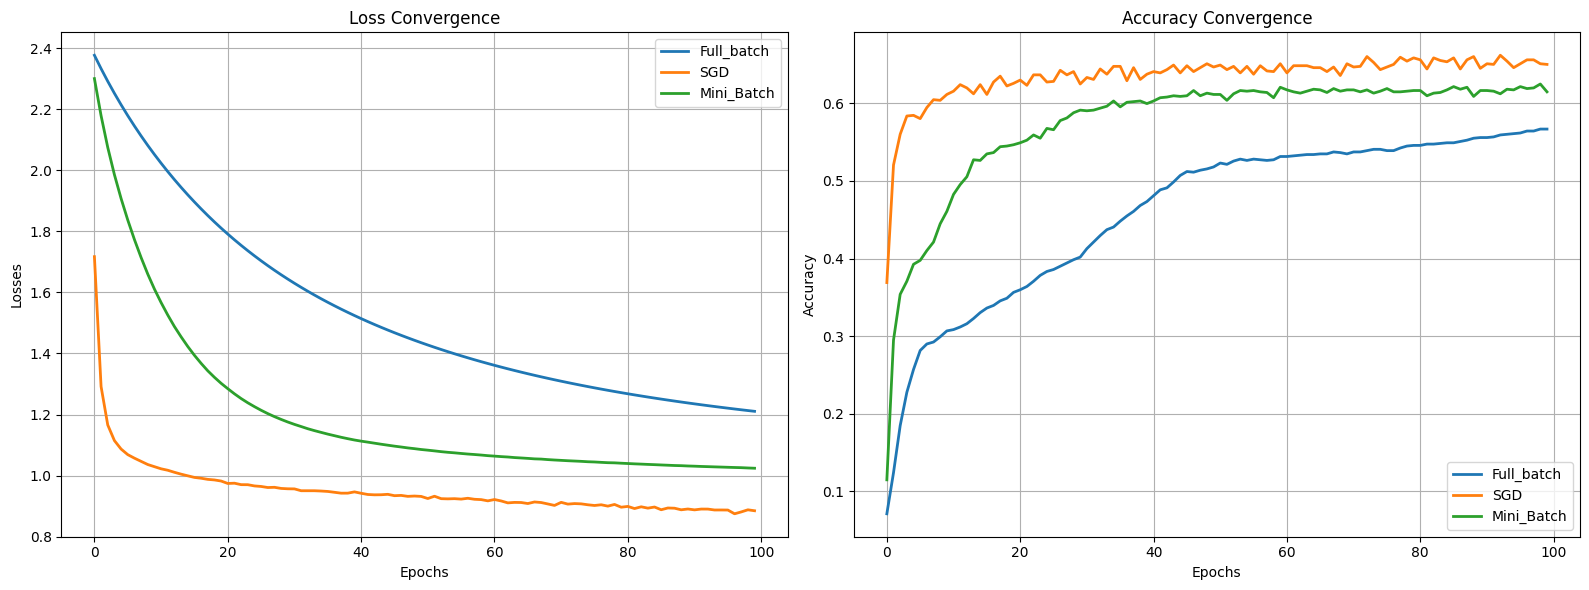

In [21]:
# --------------------------------------------------------------
# 📊 OPTIMIZER PERFORMANCE VISUALIZATION
# --------------------------------------------------------------
# This section visualizes the training behavior of three optimizers:
# - Full-Batch Gradient Descent (GD)
# - Stochastic Gradient Descent (SGD)
# - Mini-Batch SGD
# The left graph shows how the loss decreases over epochs (convergence).
# The right graph shows how model accuracy improves during training.
# --------------------------------------------------------------

epochs = len(train_losses)

plt.figure(figsize=(16, 6))

# --------------------------------------------------------------
# 🔹 LOSS CONVERGENCE CURVES
# --------------------------------------------------------------
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses_gd, label='Full_batch', lw=2)
plt.plot(range(epochs), train_losses_sgd, label='SGD', lw=2)
plt.plot(range(epochs), train_losses_mb, label='Mini_Batch', lw=2)
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Loss Convergence')
plt.legend()
plt.grid(True)

# --------------------------------------------------------------
# 🔹 ACCURACY CONVERGENCE CURVES
# --------------------------------------------------------------
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracy_gd, label='Full_batch', lw=2)
plt.plot(range(epochs), train_accuracy_sgd, label='SGD', lw=2)
plt.plot(range(epochs), train_accuracy_mb, label='Mini_Batch', lw=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Convergence')
plt.legend()
plt.grid(True)

# --------------------------------------------------------------
# 🧩 LAYOUT & DISPLAY
# --------------------------------------------------------------
plt.tight_layout()
plt.show()


***======================================================================***  
***NOTE: Interpretation of the Optimizer Comparison Graphs***  
***======================================================================***  

***--------------------------------------------------------------***  
***📉 Loss Convergence***  
***--------------------------------------------------------------***  
- **SGD (Per Sample):** Shows the fastest initial loss drop, but the curve is **noisy and unstable**.  
- **Mini-Batch SGD:** Displays a **smooth and fast descent**, offering a strong balance between **speed and stability**.  
- **Full-Batch GD:** Converges **steadily but slowly**, as its updates are too infrequent for rapid learning.  

***--------------------------------------------------------------***  
***📈 Accuracy Over Epochs***  
***--------------------------------------------------------------***  
- **SGD:** Achieves **high accuracy early**, but exhibits **fluctuations** due to noisy updates.  
- **Mini-Batch SGD:** Provides **consistent and steadily improving accuracy** with fewer fluctuations.  
- **Full-Batch GD:** Improves **slowly** and often reaches **lower final accuracy** than the other two optimizers.  

***--------------------------------------------------------------***  
***🧠 Key Insight***  
***--------------------------------------------------------------***  
***Mini-Batch SGD*** offers the **best compromise** among all optimization strategies:  
- ⚙️ **Efficient GPU utilization**  
- 📉 **Stable gradient updates**  
- ⚡ **Faster convergence** than Full-Batch GD  
- 🌊 **Smoother training** than per-sample SGD  

✅ ***This is why Mini-Batch training is the standard approach in modern deep learning!***  

➡️ ***Next Step:*** Compare these optimizers on the **test set** using **confusion matrices** and **final accuracy metrics.***  
***--------------------------------------------------------------***


***MODEL EVALUATION ON TEST SET***

✅ Test Accuracy (Adam Optimizer): 0.5825


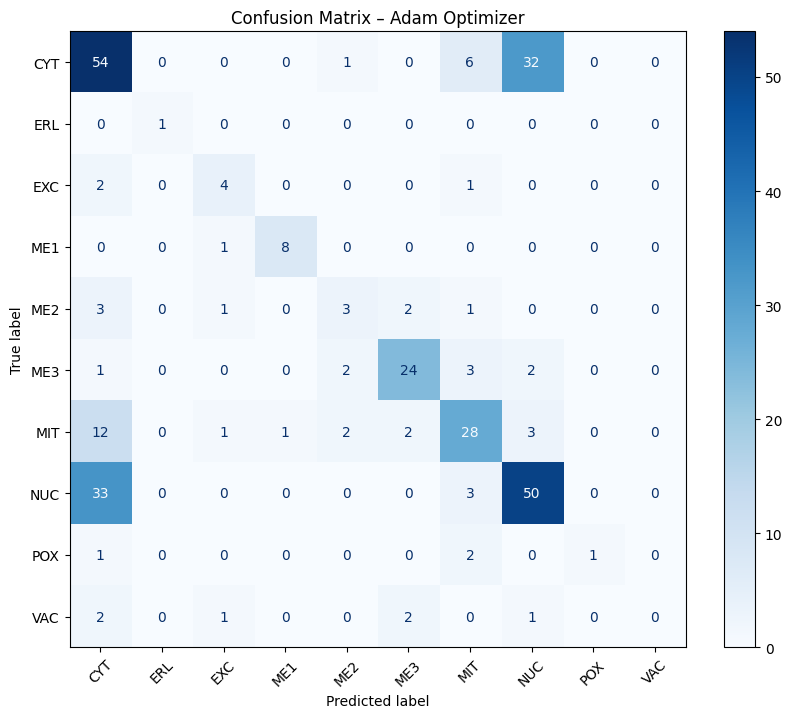

✅ Test Accuracy (Gradient Descent (Full Batch)): 0.0875


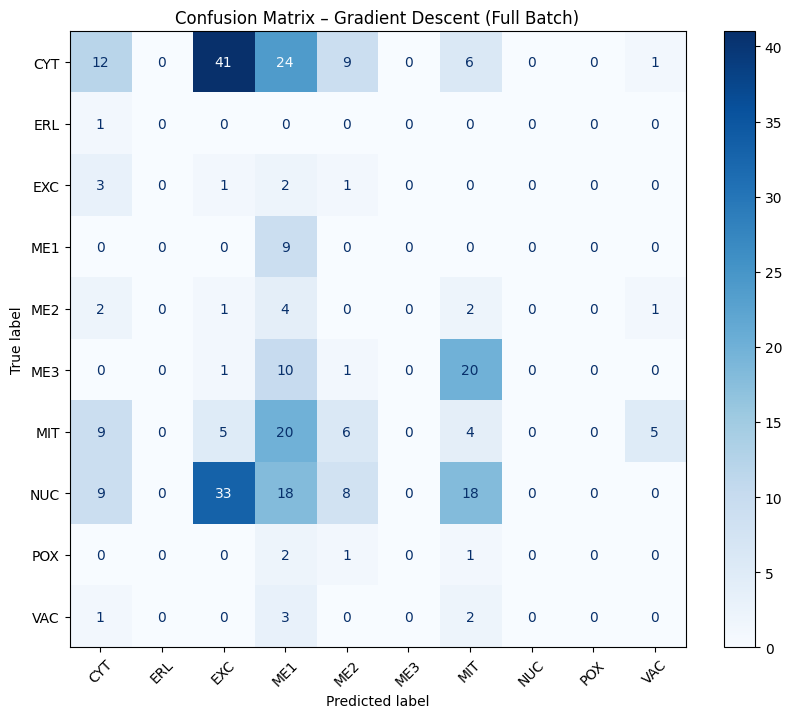

✅ Test Accuracy (Stochastic Gradient Descent (Per Sample)): 0.5960


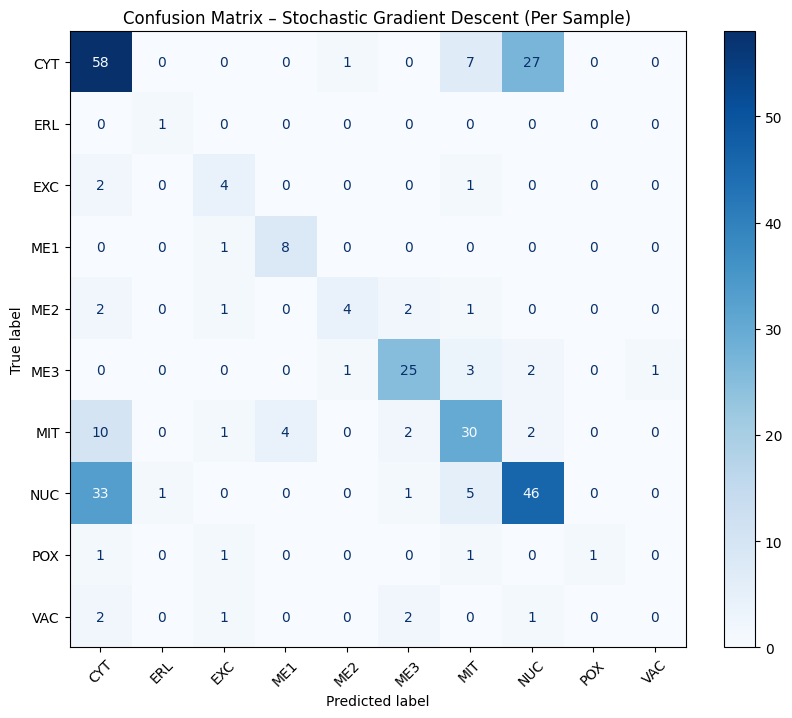

✅ Test Accuracy (Mini-Batch SGD): 0.5926


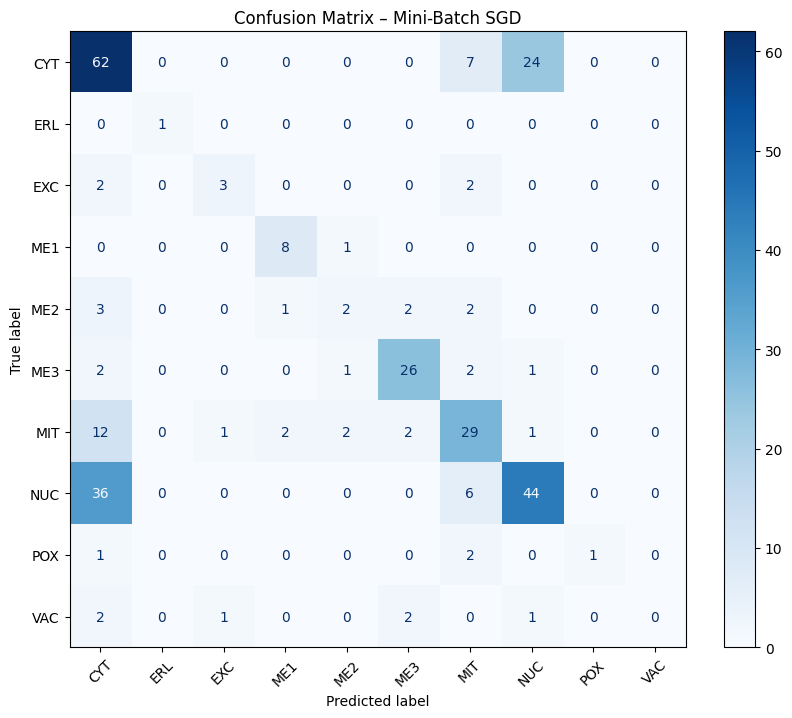

In [22]:
# --------------------------------------------------------------
# 🧠 MODEL EVALUATION USING CONFUSION MATRIX & ACCURACY
# --------------------------------------------------------------
# This section defines a helper function to evaluate trained models
# using the following metrics and visualizations:
#   - Accuracy Score (via sklearn)
#   - Confusion Matrix visualization for class performance
#
# Models evaluated:
#   1. Adam Optimizer
#   2. Full-Batch Gradient Descent (GD)
#   3. Stochastic Gradient Descent (SGD - per sample)
#   4. Mini-Batch SGD
# --------------------------------------------------------------

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# --------------------------------------------------------------
# ⚙️ EVALUATION FUNCTION
# --------------------------------------------------------------
def evaluate_model(model, X_test, y_test, class_names, title):
    """
    Evaluate a trained PyTorch model on test data and visualize performance.
    - Displays test accuracy.
    - Shows a confusion matrix heatmap.
    """

    # Set model to evaluation mode
    model.eval()
    
    # Disable gradient tracking for efficiency
    with torch.no_grad():
        outputs = model(X_test)
        _, preds = torch.max(outputs, 1)  # Predicted class indices

    # Convert tensors to numpy arrays for sklearn functions
    y_true = y_test.cpu().numpy()
    y_pred = preds.cpu().numpy()

    # --------------------------------------------------------------
    # 📈 CALCULATE TEST ACCURACY
    # --------------------------------------------------------------
    acc = accuracy_score(y_true, y_pred)
    print(f"✅ Test Accuracy ({title}): {acc:.4f}")

    # --------------------------------------------------------------
    # 📊 CONFUSION MATRIX VISUALIZATION
    # --------------------------------------------------------------
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Display matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title(f"Confusion Matrix – {title}")
    plt.show()

# --------------------------------------------------------------
# 🚀 EVALUATE ALL MODELS
# --------------------------------------------------------------
evaluate_model(model_ad, X_test_tensor, y_test_tensor, classes_names, "Adam Optimizer")
evaluate_model(model_gd, X_test_tensor, y_test_tensor, classes_names, "Gradient Descent (Full Batch)")
evaluate_model(model_sgd, X_test_tensor, y_test_tensor, classes_names, "Stochastic Gradient Descent (Per Sample)")
evaluate_model(model_mb, X_test_tensor, y_test_tensor, classes_names, "Mini-Batch SGD")


***======================================================================***  
***NOTE: Understanding Overfitting in Machine Learning***  
***======================================================================***  

***--------------------------------------------------------------***  
***📘 What Is Overfitting?***  
***--------------------------------------------------------------***  
***Overfitting occurs when a model learns the training data too well — including its noise, randomness, and outliers — instead of learning the true underlying patterns.***  

***When this happens:***  
- ✅ ***Training accuracy becomes extremely high.***  
- ❌ ***Validation/Test accuracy stops improving or even worsens.***  
- ❌ ***The model performs poorly on unseen (new) data.***  

***--------------------------------------------------------------***  
***⚠️ Why Does Overfitting Happen?***  
***--------------------------------------------------------------***  
***Overfitting commonly arises due to:***  
- ***A model that is too complex (many neurons, layers, or parameters).***  
- ***Insufficient training data relative to model size.***  
- ***Lack of regularization (e.g., no Dropout, no L2 penalty).***  
- ***Excessive training epochs, allowing the model to memorize data noise.***  


***ADDING VALIDATION SET TO CHECK FOR MODEL OVERFITTING***

In [23]:
# ==============================================================
# 📘 DATA SPLITTING – TRAIN, VALIDATION, AND TEST SETS
# ==============================================================
# ✅ Objective:
#    Split the scaled and encoded dataset into:
#    - Training (70%)
#    - Validation (15%)
#    - Testing (15%)
# ==============================================================
from sklearn.model_selection import train_test_split

# --------------------------------------------------------------
# STEP 1️⃣ – Split into Training and Temporary (Validation + Test)
# --------------------------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, 
    y_encoded, 
    random_state=42, 
    stratify=y_encoded, 
    test_size=0.3  # 30% for validation + test
)

# --------------------------------------------------------------
# STEP 2️⃣ – Split Temporary Data into Validation and Test Sets
# --------------------------------------------------------------
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    random_state=42, 
    test_size=0.5,  # Half of 30% → 15% each
    stratify=y_temp
)

# --------------------------------------------------------------
# STEP 3️⃣ – Display Dataset Shapes and Class Info
# --------------------------------------------------------------
print(f"✅ Train set: {X_train.shape}")
print(f"✅ Validation set: {X_val.shape}")
print(f"✅ Test set: {X_test.shape}")
print(f"✅ Number of Classes: {len(label_encoder.classes_)}")
print(f"✅ Class Names: {label_encoder.classes_}")


✅ Train set: (1038, 8)
✅ Validation set: (223, 8)
✅ Test set: (223, 8)
✅ Number of Classes: 10
✅ Class Names: ['CYT' 'ERL' 'EXC' 'ME1' 'ME2' 'ME3' 'MIT' 'NUC' 'POX' 'VAC']


In [24]:
# ==============================================================
# 🎯 DATA CONVERSION – NUMPY ARRAYS TO PYTORCH TENSORS
# ==============================================================
# ✅ Objective:
#    Convert training, validation, and test sets into PyTorch tensors
#    suitable for model input and training.
# ==============================================================
import torch

# --------------------------------------------------------------
# STEP 1️⃣ – Convert Feature Matrices to Float Tensors
# --------------------------------------------------------------
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)

# --------------------------------------------------------------
# STEP 2️⃣ – Convert Labels to Long Tensors (for Classification)
# --------------------------------------------------------------
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)


***MITIGATING OVERFITTING USING DROPOUT TECHNIQUE***

***======================================================================***  
***NOTE: Mitigating Overfitting Using Dropout Technique***  
***======================================================================***  

***--------------------------------------------------------------***  
***1️⃣ What Is Dropout?***  
***--------------------------------------------------------------***  
▪ ***Definition:***  
Dropout is a **regularization technique** used in neural networks to **reduce overfitting** by randomly “dropping out” (i.e., deactivating) a fraction of neurons during training.  

▪ ***Conceptually:***  
At each training step, a random subset of neurons is ignored — they neither contribute to the forward pass nor participate in backpropagation. This prevents neurons from becoming overly dependent on specific other neurons.  

---

***--------------------------------------------------------------***  
***2️⃣ Why Dropout Helps Prevent Overfitting***  
***--------------------------------------------------------------***  
- Forces the network to **learn redundant representations**, improving robustness.  
- Reduces **co-adaptation** between neurons.  
- Encourages the network to **generalize better** on unseen data.  
- Acts as a form of **model averaging**, since each dropout mask represents a different sub-network.  

---

***--------------------------------------------------------------***  
***3️⃣ How Dropout Works During Training vs. Inference***  
***--------------------------------------------------------------***  
- **During Training:** Randomly zeroes out a fraction of activations (e.g., 20–50%).  
- **During Inference:** Dropout is **disabled** — all neurons are active, but their outputs are scaled down by the dropout rate to maintain balance.  

---

***--------------------------------------------------------------***  
***4️⃣ Typical Dropout Rates***  
***--------------------------------------------------------------***  
- **Input Layer:** 0.1 – 0.2  
- **Hidden Layers:** 0.3 – 0.5  
- **Output Layer:** Usually no dropout  


In [36]:
# --------------------------------------------------------------
# Model Definition: MLP with Dropout Regularization
# --------------------------------------------------------------

import torch.nn as nn

# --------------------------------------------------------------
# Define Neural Network with Dropout to Reduce Overfitting
# --------------------------------------------------------------
class ModelDropout(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(ModelDropout, self).__init__()
        
        # ----------------------------------------------------------
        # Sequential model architecture
        # ----------------------------------------------------------
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),   # Input → Hidden Layer
            nn.ReLU(),                          # Non-linear activation
            nn.Dropout(dropout_rate),           # Dropout regularization
            nn.Linear(hidden_dim, output_dim)   # Hidden → Output Layer
        )

    # --------------------------------------------------------------
    # Forward Pass
    # --------------------------------------------------------------
    def forward(self, x):
        return self.net(x)

# --------------------------------------------------------------
# Model Initialization Parameters
# --------------------------------------------------------------
input_dim = X_train_tensor.shape[1]                     # Number of input features
hidden_dim = 32                                         # Number of hidden neurons
output_dim = len(label_encoder.classes_)               # Number of output classes
dropout_rate = 0.5                                      # Dropout rate (50%)

# --------------------------------------------------------------
# Instantiate Model
# --------------------------------------------------------------
model_dropout_test = ModelDropout(input_dim, hidden_dim, output_dim, dropout_rate)
print(model_dropout_test)

ModelDropout(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [39]:
# --------------------------------------------------------------
# Training MLP Model with Dropout Regularization
# --------------------------------------------------------------

import torch
import torch.nn as nn

# --------------------------------------------------------------
# Define Loss Function and Optimizer
# --------------------------------------------------------------
criterion = nn.CrossEntropyLoss()                                      # Cross-Entropy Loss for multi-class classification
optimizer = torch.optim.Adam(model_dropout_test.parameters(), lr=0.001)  # Adam optimizer with learning rate = 0.001

# --------------------------------------------------------------
# Initialize Metric Storage
# --------------------------------------------------------------
train_losses_dropout = []
val_losses_dropout = []
epochs = 1000  # Number of training epochs

# --------------------------------------------------------------
# Training Loop
# --------------------------------------------------------------
for epoch in range(epochs):

    # ----------------------------------------------------------
    # Training Phase
    # ----------------------------------------------------------
    model_dropout_test.train()                                   # Enable training mode (activates dropout)
    outputs = model_dropout_test(X_train_tensor)                 # Forward pass
    loss = criterion(outputs, y_train_tensor)                    # Compute training loss

    optimizer.zero_grad()                                        # Reset gradients
    loss.backward()                                              # Backpropagation
    optimizer.step()                                             # Update model parameters
    train_losses_dropout.append(loss.item())                             # Record training loss

    # ----------------------------------------------------------
    # Validation Phase
    # ----------------------------------------------------------
    model_dropout_test.eval()                                    # Evaluation mode (disables dropout)
    with torch.no_grad():                                        # Disable gradient calculation
        val_outputs = model_dropout_test(X_val_tensor)           # Forward pass on validation data
        val_loss = criterion(val_outputs, y_val_tensor)          # Compute validation loss
        val_losses_dropout.append(val_loss.item())                       # Record validation loss

    # ----------------------------------------------------------
    # Progress Logging
    # ----------------------------------------------------------
    if (epoch + 1) % 50 == 0:
        print(f"[Dropout] Epoch {epoch + 1} | Train Loss = {loss.item():.4f} | Val Loss = {val_loss.item():.4f}")


[Dropout] Epoch 50 | Train Loss = 1.9119 | Val Loss = 1.8838
[Dropout] Epoch 100 | Train Loss = 1.5720 | Val Loss = 1.5296
[Dropout] Epoch 150 | Train Loss = 1.3886 | Val Loss = 1.3472
[Dropout] Epoch 200 | Train Loss = 1.3015 | Val Loss = 1.2634
[Dropout] Epoch 250 | Train Loss = 1.2547 | Val Loss = 1.2185
[Dropout] Epoch 300 | Train Loss = 1.2204 | Val Loss = 1.1921
[Dropout] Epoch 350 | Train Loss = 1.1930 | Val Loss = 1.1767
[Dropout] Epoch 400 | Train Loss = 1.1782 | Val Loss = 1.1656
[Dropout] Epoch 450 | Train Loss = 1.1641 | Val Loss = 1.1569
[Dropout] Epoch 500 | Train Loss = 1.1605 | Val Loss = 1.1502
[Dropout] Epoch 550 | Train Loss = 1.1544 | Val Loss = 1.1450
[Dropout] Epoch 600 | Train Loss = 1.1540 | Val Loss = 1.1407
[Dropout] Epoch 650 | Train Loss = 1.1293 | Val Loss = 1.1373
[Dropout] Epoch 700 | Train Loss = 1.1300 | Val Loss = 1.1345
[Dropout] Epoch 750 | Train Loss = 1.1320 | Val Loss = 1.1345
[Dropout] Epoch 800 | Train Loss = 1.1160 | Val Loss = 1.1315
[Dropout]

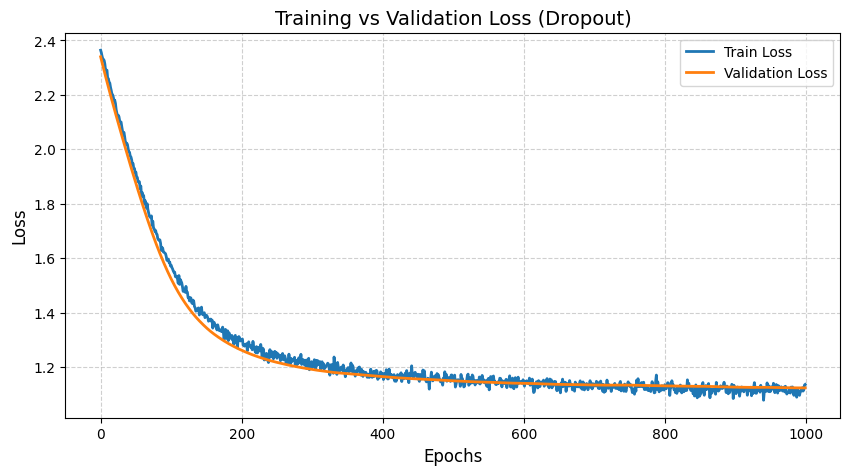

In [40]:
# --------------------------------------------------------------
# Visualization: Training vs Validation Loss (Dropout Regularization)
# --------------------------------------------------------------

import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Plot Loss Curves
# --------------------------------------------------------------
plt.figure(figsize=(10, 5))                                               # Set figure size
plt.plot(train_losses_dropout, label='Train Loss', linewidth=2)           # Plot training loss
plt.plot(val_losses_dropout, label='Validation Loss', linewidth=2)        # Plot validation loss

# --------------------------------------------------------------
# Graph Formatting
# --------------------------------------------------------------
plt.title("Training vs Validation Loss (Dropout)", fontsize=14)           # Title
plt.xlabel("Epochs", fontsize=12)                                         # X-axis label
plt.ylabel("Loss", fontsize=12)                                           # Y-axis label
plt.legend()                                                              # Display legend
plt.grid(True, linestyle='--', alpha=0.6)                                 # Add gridlines for readability

# --------------------------------------------------------------
# Show Plot
# --------------------------------------------------------------
plt.show()


***MITIGATING OVERFITTING WITH L2 REGULARIZATION***

***======================================================================***  
***NOTE: Mitigating Overfitting Using L2 Regularization***  
***======================================================================***  

***--------------------------------------------------------------***  
***1️⃣ What Is L2 Regularization?***  
***--------------------------------------------------------------***  
▪ ***Definition:***  
L2 Regularization, also known as **weight decay**, is a technique to prevent overfitting by **penalizing large weights** in the neural network.  

▪ ***Conceptually:***  
During training, the loss function is modified to include a term proportional to the **sum of the squares of all weights**:  
***Loss_total = Loss_original + λ * Σ(weights²)***  
where **λ** is the regularization strength.  

---

***--------------------------------------------------------------***  
***2️⃣ Why L2 Helps Prevent Overfitting***  
***--------------------------------------------------------------***  
- Encourages **smaller weights**, which leads to **simpler models**.  
- Reduces the model's tendency to **memorize noise** in the training data.  
- Improves **generalization** on unseen data.  

---

***--------------------------------------------------------------***  
***3️⃣ How L2 Works During Training***  
***--------------------------------------------------------------***  
- During gradient descent, each weight is **slightly shrunk** in addition to the normal update:  
  - New weight = weight - learning_rate * (gradient + λ * weight)  
- This penalizes large weights while keeping useful patterns.  

---

***--------------------------------------------------------------***  
***4️⃣ Typical Usage***  
***--------------------------------------------------------------***  
- Commonly used in **linear models, logistic regression, and neural networks**.  
- In PyTorch, you can set L2 regularization with the **weight_decay** parameter in optimizers:  
  ```python
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
  ```  

---

***--------------------------------------------------------------***  
***5️⃣ Key Takeaways***  
***--------------------------------------------------------------***  
- L2 Regularization is a **simple and effective** method to reduce overfitting.  
- Works by **constraining weights**, preventing overly complex models.  
- Often combined with **Dropout** for stronger regularization in deep learning.  

***======================================================================***


In [41]:
# --------------------------------------------------------------
# Training MLP Model with L2 Regularization (Weight Decay)
# --------------------------------------------------------------

import torch
import torch.nn as nn

# --------------------------------------------------------------
# Define Neural Network with L2 Regularization
# --------------------------------------------------------------
class YeastModelL2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(YeastModelL2, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Input → Hidden Layer
            nn.ReLU(),                         # Activation
            nn.Linear(hidden_dim, output_dim)  # Hidden → Output Layer
        )

    # ----------------------------------------------------------
    # Forward Pass
    # ----------------------------------------------------------
    def forward(self, x):
        return self.network(x)

# --------------------------------------------------------------
# Model, Loss Function, and Optimizer
# --------------------------------------------------------------
model_l2 = YeastModelL2(
    input_dim=X_train_tensor.shape[1],
    hidden_dim=32,
    output_dim=len(label_encoder.classes_)
)

criterion = nn.CrossEntropyLoss()                                         # Multi-class classification loss
optimizer = torch.optim.Adam(model_l2.parameters(), lr=0.001, weight_decay=1e-4)  # Adam with L2 regularization

# --------------------------------------------------------------
# Initialize Metric Storage
# --------------------------------------------------------------
train_losses_l2 = []
val_losses_l2 = []
epochs = 1000

# --------------------------------------------------------------
# Training Loop
# --------------------------------------------------------------
for epoch in range(epochs):

    # ----------------------------------------------------------
    # Training Phase
    # ----------------------------------------------------------
    model_l2.train()                                      # Enable training mode
    outputs_l2 = model_l2(X_train_tensor)                # Forward pass
    loss_l2 = criterion(outputs_l2, y_train_tensor)      # Compute training loss

    optimizer.zero_grad()                                 # Reset gradients
    loss_l2.backward()                                   # Backpropagation
    optimizer.step()                                     # Update model parameters
    train_losses_l2.append(loss_l2.item())              # Record training loss

    # ----------------------------------------------------------
    # Validation Phase
    # ----------------------------------------------------------
    model_l2.eval()                                      # Evaluation mode
    with torch.no_grad():
        val_outputs_l2 = model_l2(X_val_tensor)         # Forward pass on validation set
        val_loss_l2 = criterion(val_outputs_l2, y_val_tensor)  # Compute validation loss
        val_losses_l2.append(val_loss_l2.item())        # Record validation loss

    # ----------------------------------------------------------
    # Progress Logging Every 50 Epochs
    # ----------------------------------------------------------
    if (epoch + 1) % 50 == 0:
        print(f"[L2 REGULARIZATION] Epoch {epoch + 1} | Train Loss = {loss_l2.item():.4f} | Val Loss = {val_loss_l2.item():.4f}")


[L2 REGULARIZATION] Epoch 50 | Train Loss = 1.8688 | Val Loss = 1.8747
[L2 REGULARIZATION] Epoch 100 | Train Loss = 1.5307 | Val Loss = 1.5463
[L2 REGULARIZATION] Epoch 150 | Train Loss = 1.3051 | Val Loss = 1.3409
[L2 REGULARIZATION] Epoch 200 | Train Loss = 1.1789 | Val Loss = 1.2367
[L2 REGULARIZATION] Epoch 250 | Train Loss = 1.1122 | Val Loss = 1.1877
[L2 REGULARIZATION] Epoch 300 | Train Loss = 1.0730 | Val Loss = 1.1632
[L2 REGULARIZATION] Epoch 350 | Train Loss = 1.0463 | Val Loss = 1.1494
[L2 REGULARIZATION] Epoch 400 | Train Loss = 1.0256 | Val Loss = 1.1415
[L2 REGULARIZATION] Epoch 450 | Train Loss = 1.0086 | Val Loss = 1.1357
[L2 REGULARIZATION] Epoch 500 | Train Loss = 0.9930 | Val Loss = 1.1320
[L2 REGULARIZATION] Epoch 550 | Train Loss = 0.9807 | Val Loss = 1.1280
[L2 REGULARIZATION] Epoch 600 | Train Loss = 0.9708 | Val Loss = 1.1245
[L2 REGULARIZATION] Epoch 650 | Train Loss = 0.9619 | Val Loss = 1.1225
[L2 REGULARIZATION] Epoch 700 | Train Loss = 0.9539 | Val Loss = 

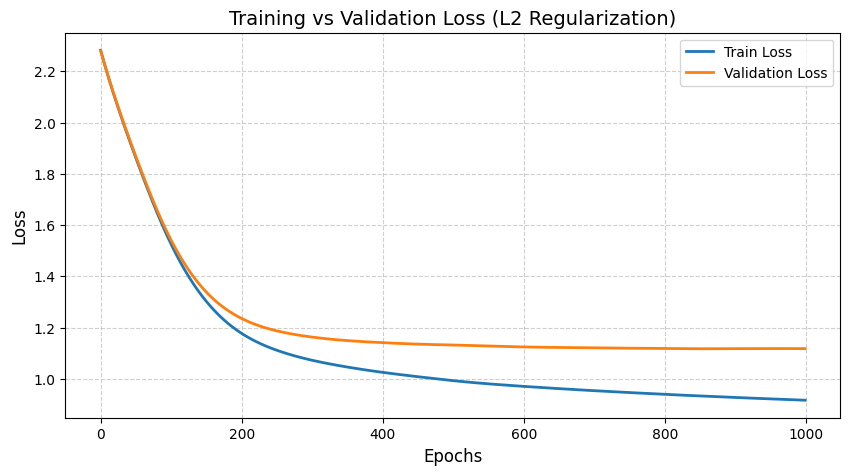

In [42]:
# --------------------------------------------------------------
# Visualization: Training vs Validation Loss (L2 Regularization)
# --------------------------------------------------------------

import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Plot Loss Curves
# --------------------------------------------------------------
plt.figure(figsize=(10, 5))                                      # Set figure size
plt.plot(train_losses_l2, label='Train Loss', linewidth=2)       # Training loss
plt.plot(val_losses_l2, label='Validation Loss', linewidth=2)    # Validation loss

# --------------------------------------------------------------
# Graph Formatting
# --------------------------------------------------------------
plt.title("Training vs Validation Loss (L2 Regularization)", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# --------------------------------------------------------------
# Show Plot
# --------------------------------------------------------------
plt.show()


***MITIGATE OVERFITTING WITH DROPOUT AND L2 REGULARIZATION***

***What Is Dropout + L2 Regularization?***
--------------------------------------------------------------
▪ Definition:
Dropout combined with L2 regularization is a technique that reduces overfitting by both randomly deactivating neurons during training and penalizing large weights in the network.

▪ Conceptually:
At each training step, some neurons are dropped (Dropout) while all weights are slightly shrunk toward zero (L2), forcing the network to learn robust and simpler representations.

--------------------------------------------------------------
***2️⃣ Why It Helps Prevent Overfitting***
--------------------------------------------------------------
- Dropout prevents neurons from co-adapting too strongly, encouraging redundancy in feature learning.
- L2 regularization discourages excessively large weights, simplifying the model.
- Together, they reduce memorization of noise and improve generalization on unseen data.

--------------------------------------------------------------
***3️⃣ How It Works During Training vs. Inference***
--------------------------------------------------------------
- During Training: Dropout randomly zeroes out activations; L2 adds a penalty proportional to the square of weights.
- During Inference: Dropout is disabled; L2 remains active through the weight constraints applied during training.

--------------------------------------------------------------
***4️⃣ Typical Settings***
--------------------------------------------------------------
- Dropout Rate: 0.2 – 0.5 depending on layer and network size.
- L2 Weight Decay (λ): 1e-4 to 1e-2 is commonly used in neural networks.
- Combined, these hyperparameters may require tuning for optimal performance.

--------------------------------------------------------------
***5️⃣ Key Takeaways***
--------------------------------------------------------------
- Dropout + L2 is a strong regularization combo, especially useful for deeper or larger networks.
- It helps the network learn robust features while avoiding overfitting.
- Excessive regularization can cause underfitting, so balance is key.

======================================================================

In [64]:
# --------------------------------------------------------------
# Model Definition: MLP with Dropout + L2 Regularization
# --------------------------------------------------------------

import torch
import torch.nn as nn

# --------------------------------------------------------------
# Define Neural Network with Dropout
# --------------------------------------------------------------
class ModelDropoutL2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(ModelDropoutL2, self).__init__()
        
        # ----------------------------------------------------------
        # Sequential model architecture
        # ----------------------------------------------------------
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),   # Input → Hidden Layer
            nn.ReLU(),                          # Non-linear activation
            nn.Dropout(dropout_rate),           # Dropout regularization
            nn.Linear(hidden_dim, output_dim)   # Hidden → Output Layer
        )

    # ----------------------------------------------------------
    # Forward Pass
    # ----------------------------------------------------------
    def forward(self, x):
        return self.net(x)

# --------------------------------------------------------------
# Model Initialization, Loss Function, Optimizer
# --------------------------------------------------------------
input_dim = X_train_tensor.shape[1]
hidden_dim = 32
output_dim = len(label_encoder.classes_)
dropout_rate = 0.5

model_dropout_l2 = ModelDropoutL2(input_dim, hidden_dim, output_dim, dropout_rate)
criterion = nn.CrossEntropyLoss()                                   # Multi-class classification loss
optimizer = torch.optim.Adam(model_dropout_l2.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization via weight_decay

# --------------------------------------------------------------
# Initialize metric storage
# --------------------------------------------------------------
train_losses_dropout_L2 = []
val_losses_dropout_L2 = []
num_epochs = 1000

# --------------------------------------------------------------
# Training Loop
# --------------------------------------------------------------
for epoch in range(num_epochs):

    # ----------------------------------------------------------
    # Training Step
    # ----------------------------------------------------------
    model_dropout_l2.train()
    y_pred = model_dropout_l2(X_train_tensor)                # Forward pass
    loss = criterion(y_pred, y_train_tensor)                # Compute loss
    train_losses_dropout_L2.append(loss.item())             # Store train loss

    optimizer.zero_grad()                                   # Reset gradients
    loss.backward()                                        # Backpropagation
    optimizer.step()                                       # Update weights

    # ----------------------------------------------------------
    # Validation Step
    # ----------------------------------------------------------
    model_dropout_l2.eval()
    with torch.no_grad():
        val_output = model_dropout_l2(X_val_tensor)
        val_loss = criterion(val_output, y_val_tensor)
        val_losses_dropout_L2.append(val_loss.item())

    # ----------------------------------------------------------
    # Print progress every 50 epochs
    # ----------------------------------------------------------
    if (epoch + 1) % 50 == 0:
        print(f"[L2+Dropout] Epoch {epoch+1}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}")


[L2+Dropout] Epoch 50: Train Loss = 1.8925, Val Loss = 1.8614
[L2+Dropout] Epoch 100: Train Loss = 1.5747, Val Loss = 1.5452
[L2+Dropout] Epoch 150: Train Loss = 1.3946, Val Loss = 1.3672
[L2+Dropout] Epoch 200: Train Loss = 1.2927, Val Loss = 1.2761
[L2+Dropout] Epoch 250: Train Loss = 1.2314, Val Loss = 1.2298
[L2+Dropout] Epoch 300: Train Loss = 1.2309, Val Loss = 1.2033
[L2+Dropout] Epoch 350: Train Loss = 1.1846, Val Loss = 1.1877
[L2+Dropout] Epoch 400: Train Loss = 1.1788, Val Loss = 1.1771
[L2+Dropout] Epoch 450: Train Loss = 1.1516, Val Loss = 1.1695
[L2+Dropout] Epoch 500: Train Loss = 1.1692, Val Loss = 1.1652
[L2+Dropout] Epoch 550: Train Loss = 1.1625, Val Loss = 1.1604
[L2+Dropout] Epoch 600: Train Loss = 1.1127, Val Loss = 1.1563
[L2+Dropout] Epoch 650: Train Loss = 1.1618, Val Loss = 1.1537
[L2+Dropout] Epoch 700: Train Loss = 1.1266, Val Loss = 1.1516
[L2+Dropout] Epoch 750: Train Loss = 1.1340, Val Loss = 1.1491
[L2+Dropout] Epoch 800: Train Loss = 1.1716, Val Loss = 

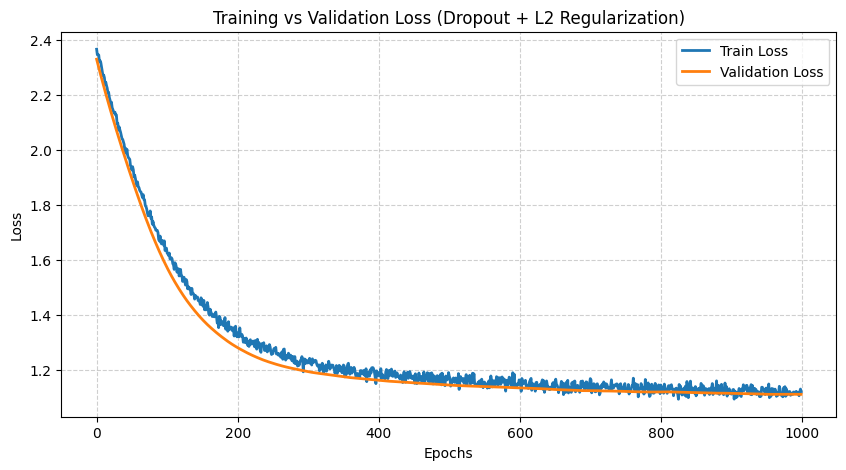

In [46]:
# --------------------------------------------------------------
# Plot Training vs Validation Loss for Dropout + L2 Regularization
# --------------------------------------------------------------

import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Create Figure
# --------------------------------------------------------------
plt.figure(figsize=(10, 5))

# --------------------------------------------------------------
# Plot Training Loss
# --------------------------------------------------------------
plt.plot(train_losses_dropout_L2, label='Train Loss', linewidth=2)

# --------------------------------------------------------------
# Plot Validation Loss
# --------------------------------------------------------------
plt.plot(val_losses_dropout_L2, label='Validation Loss', linewidth=2)

# --------------------------------------------------------------
# Labels, Title, Legend, and Grid
# --------------------------------------------------------------
plt.title("Training vs Validation Loss (Dropout + L2 Regularization)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# --------------------------------------------------------------
# Display Plot
# --------------------------------------------------------------
plt.show()


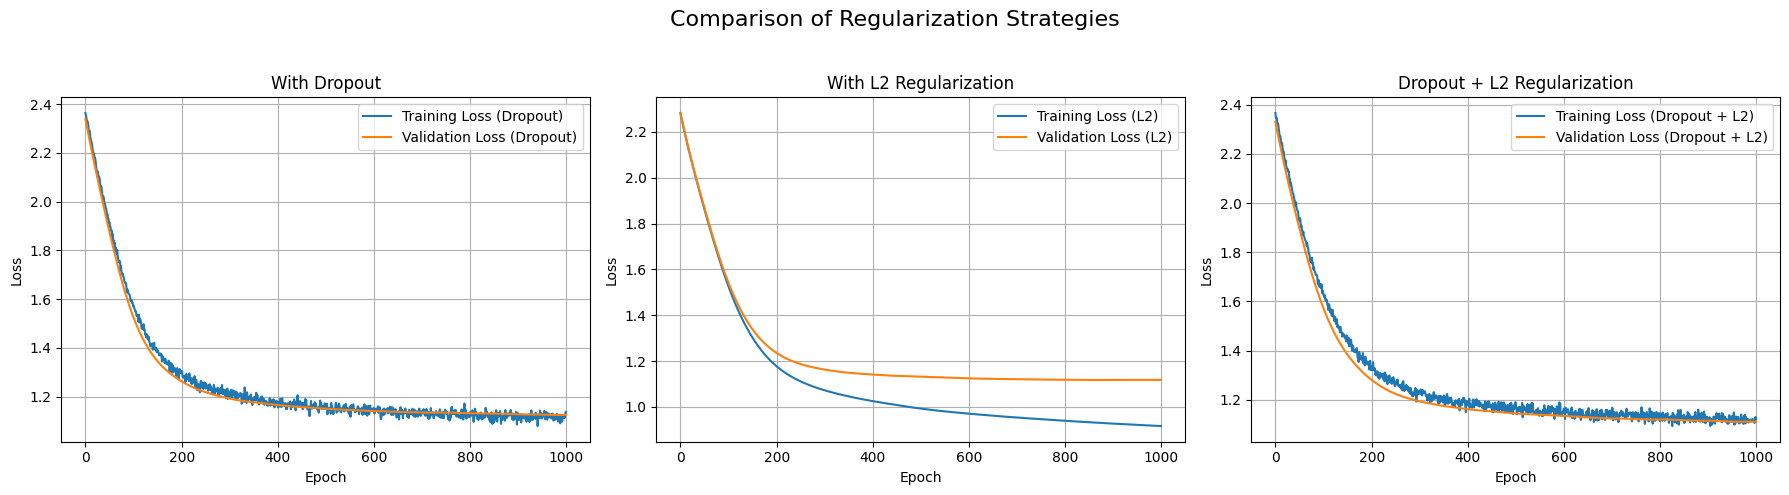

In [53]:
# --------------------------------------------------------------
# Visualization: Comparison of Regularization Strategies (Single Row)
# --------------------------------------------------------------

import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Create 1x3 subplot grid
# --------------------------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# --------------------------------------------------------------
# Plot 1: Dropout Regularization
# --------------------------------------------------------------
axs[0].plot(train_losses_dropout, label="Training Loss (Dropout)")
axs[0].plot(val_losses_dropout, label="Validation Loss (Dropout)")
axs[0].set_title("With Dropout")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)

# --------------------------------------------------------------
# Plot 2: L2 Regularization
# --------------------------------------------------------------
axs[1].plot(train_losses_l2, label="Training Loss (L2)")
axs[1].plot(val_losses_l2, label="Validation Loss (L2)")
axs[1].set_title("With L2 Regularization")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

# --------------------------------------------------------------
# Plot 3: Dropout + L2 Regularization
# --------------------------------------------------------------
axs[2].plot(train_losses_dropout_L2, label="Training Loss (Dropout + L2)")
axs[2].plot(val_losses_dropout_L2, label="Validation Loss (Dropout + L2)")
axs[2].set_title("Dropout + L2 Regularization")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Loss")
axs[2].legend()
axs[2].grid(True)

# --------------------------------------------------------------
# Final Layout Adjustments
# --------------------------------------------------------------
plt.suptitle("Comparison of Regularization Strategies", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


***EVALUATION ON TEST SET***

In [63]:
# --------------------------------------------------------------
# Evaluate Models on Test Set
# --------------------------------------------------------------

import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score
import pandas as pd

# --------------------------------------------------------------
# Function: Evaluate a Model
# --------------------------------------------------------------
def evaluate_model(model, X_test_tensor, y_test_tensor):
    """
    Evaluates a PyTorch classification model on the test set.
    Returns Accuracy, Macro F1 Score, and Precision.
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient tracking
        logits = model(X_test_tensor)                  # Forward pass
        preds = torch.argmax(logits, dim=1)           # Predicted class indices

    # Convert to numpy arrays for sklearn metrics
    y_true = y_test_tensor.cpu().numpy()
    y_pred = preds.cpu().numpy()

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    
    return acc, f1


# --------------------------------------------------------------
# Evaluate Each Regularization Model
# --------------------------------------------------------------
# Dropout Only (M1)
acc_m1, f1_m1, = evaluate_model(model_dropout_test, X_test_tensor, y_test_tensor)

# L2 Regularization Only (M2)
acc_m2, f1_m2 = evaluate_model(model_l2, X_test_tensor, y_test_tensor)

# Dropout + L2 (M3)
acc_m3, f1_m3 = evaluate_model(model_dropout_l2, X_test_tensor, y_test_tensor)

# --------------------------------------------------------------
# Create Results DataFrame
# --------------------------------------------------------------
results = {
    "Model": ["Dropout (M1)", "L2 (M2)", "Dropout + L2 (M3)"],
    "Test Accuracy": [acc_m1, acc_m2, acc_m3],
    "Macro F1 Score": [f1_m1, f1_m2, f1_m3],
    
}

results_df = pd.DataFrame(results)

# --------------------------------------------------------------
# Display Results
# --------------------------------------------------------------
print(results_df)


               Model  Test Accuracy  Macro F1 Score
0       Dropout (M1)       0.573991        0.451516
1            L2 (M2)       0.605381        0.605480
2  Dropout + L2 (M3)       0.587444        0.433184


In [65]:
# --------------------------------------------------------------
# Save the L2 Regularized Model
# --------------------------------------------------------------

import torch

# Specify the file path where the model will be saved
model_path = "yeast_model_l2.pth"

# Save the model's state dictionary
torch.save(model_l2.state_dict(), model_path)

print(f"✅ Model saved successfully at: {model_path}")


✅ Model saved successfully at: yeast_model_l2.pth


**📋 Test Performance Summary**

| Model              | Test Accuracy | Macro F1 Score |
|-------------------|---------------|----------------|
| Dropout Only (M1)  | 57.40%        | 45.15%         |
| L2 Regularization (M2) | **60.54%**   | **60.55%**     
| Dropout + L2 (M3)  | 58.74%        | 43.32%         | 

>🔍 What Do These Numbers Suggest?

✅ **L2 Regularization (M2)** performs best across all metrics:
- Achieved the **highest test accuracy**, **macro F1**, and **macro precision**.
- Penalizing large weights helped the model **generalize better**.

✅ **Dropout Only (M1)** shows moderate performance:
- Dropout reduced overfitting, but network capacity or training setup may have limited effectiveness.

⚠️ **Dropout + L2 (M3)** shows slight improvement over Dropout alone in accuracy, but F1 and precision are lower:
- Combining dropout with L2 didn’t yield additive benefits here.
- Likely due to **underfitting from too much regularization**.

>🧠 Key Takeaways

- ✅ **L2 regularization alone (M2)** was most effective for this dataset.
- ✅ **Dropout** is more useful in **larger networks or datasets prone to severe overfitting**.
- ✅ **Combining Dropout + L2** may require careful tuning of **dropout rate** and **weight decay**.

>**What If We Change the Architecture?**

- **Increase neurons (e.g., 64)?**: More expressive model, higher risk of overfitting, requires stronger regularization.  
- **Decrease neurons (e.g., 16)?**: Simpler model, may underfit, training faster but less accurate.  
- **Add hidden layers?**: Can learn deeper representations, needs more data, regularization, and training strategies like batch norm or residual connections.




-----------------------------------------------------------------------
###  Final Reflection: Generalization, Regularization, and Model Design
-----------------------------------------------------------------------

***In this notebook, we investigated how different regularization strategies impact a model’s ability to generalize — that is, to perform well on unseen data, not just the training set.***

***We experimented with Dropout, L2 Weight Decay, and a combination of both. Throughout, we observed how regularization can significantly influence both accuracy and fairness, especially in imbalanced multiclass datasets.***

***Key observations from our experiments:***

* ***Dropout performed well too, promoting simpler, more stable solutions by randomly deactivating neurons.***

* ***Combining Dropout + L2 did not improve results in this setup — likely because the model was overly constrained without careful tuning.***

* ***These results emphasize a central lesson in deep learning: regularization is powerful but not automatic. Its effectiveness depends on the architecture, dataset size, and learning dynamics. A method that works well in one scenario might underperform in another.***

* ***This connects to the concept of the bias–variance trade-off:***

* ***Underfitting occurs when the model is too simple (high bias).***

* ***Overfitting occurs when the model is too complex (high variance).***

* ***The goal is to find the sweet spot — a model expressive enough to capture meaningful patterns, yet restrained enough to generalize well.***

--------------------------------------------------------------